**Udemy 5-13. Improving CIFAR-10 Results**

Note 1: uses a larger CNN

Note 2: uses data augmentation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Transforms
#Reference: https://pytorch.org/vision/stable/transforms.html

transformer_train = transforms.Compose([
#        transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.2),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
#        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
#        transforms.RandomPerspective(),
        transforms.ToTensor(),
        ])

In [ ]:
# Loading train-data using torch-vision
train_dataset = torchvision.datasets.CIFAR10(
    root = ".",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

print(train_dataset.data.shape)
print(train_dataset.data.max())
print(train_dataset.targets)

# Loading the test-dataset
test_dataset = torchvision.datasets.CIFAR10(
    root=".",
    train=False,
    transform=transformer_train,
    download=True
)

print(test_dataset.data.shape)
print(test_dataset.data.max())
print(test_dataset.targets)

# Number of classes
K = len(set(train_dataset.targets))
print("Number of classes:", K)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
(50000, 32, 32, 3)
255
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1,

In [ ]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32),
        nn.MaxPool2d(kernel_size=2),        
        )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.MaxPool2d(kernel_size=2),        
        )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=128),
        nn.MaxPool2d(kernel_size=2),        
        )
    self.fc1 = nn.Linear(in_features=128*4*4, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=K)
    

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0),-1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x

In [ ]:
# Instantiate the CNN class
model = CNN(K)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Data Loader
# Useful because it automatically generates batches in the training loop and take care of shuffling.
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    )
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    )

In [ ]:
# Train the Model
def full_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  
  #Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    
    t0 = datetime.now()
    train_loss = []

    for inputs, targets in train_loader:
      # Move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Zeros the parameters
      optimizer.zero_grad()

      # Forward Pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and Optimize
      loss.backward()
      optimizer.step()
      
      train_loss.append(loss.item())

    # Get train-loss and test-loss
    train_loss = np.mean(train_loss) # A little misleading

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, duration: {dt}')
  return train_losses, test_losses


In [ ]:
train_losses, test_losses = full_gd(model, criterion, optimizer,train_loader, test_loader, epochs=3)

Epoch 1/3, train_loss: 1.2298, test_loss: 1.4680, duration: 0:00:15.897334
Epoch 2/3, train_loss: 0.8079, test_loss: 1.1571, duration: 0:00:15.098783
Epoch 3/3, train_loss: 0.6516, test_loss: 1.2156, duration: 0:00:15.080242


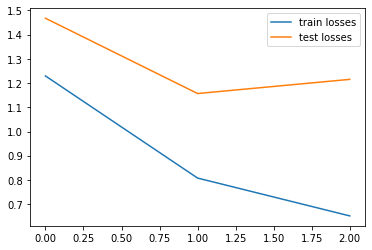

In [ ]:
plt.plot(train_losses, label="train losses")
plt.plot(test_losses, label="test losses")
plt.legend()
plt.show()

In [ ]:
# Train accuracy
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total


# Test accuracy
n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


Train acc: 0.8158, Test acc: 0.5999


In [ ]:
#plot Confusion Matrix 
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='confusion_matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without Normalization")
  
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             ha='center', # horizontalalignment
             va='center', # verticalalignment
             color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()


Confusion Matrix without Normalization
[[695  53  68  47  13  10  21   5  39  49]
 [ 53 818   5  23   2   5  24   3  13  54]
 [ 76  15 496 149  66  55 111   9   8  15]
 [ 20  16  60 593  40 132  90  20  15  14]
 [ 24   6  85 162 518  28 112  27  25  13]
 [  9   9  43 331  32 493  49  18   7   9]
 [ 10   6  84 125  12  13 733   2   8   7]
 [ 35  14  48 132 136  96  35 466  10  28]
 [184 101  23  54  10   5  11   1 541  70]
 [ 68 181  18  38  12  17  17  21  16 612]]


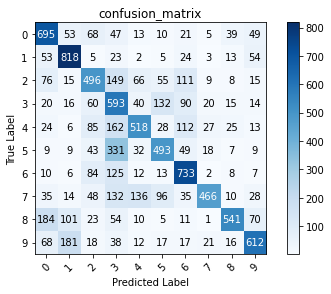

In [ ]:
# Get all predictions in an array and plot confusion matrix
x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
  # Move data to GPU
  inputs = inputs.to(device)

  # Forward Pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # Update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))


In [ ]:
# Label mapping
labels = """airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck""".split("\n")

Text(0.5, 1.0, 'True label: bird - Predicted: frog')

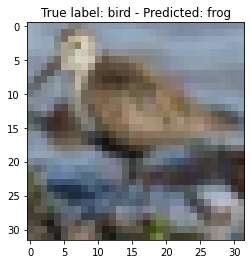

In [ ]:
# Show Some misclassified example
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title(f"True label: {labels[y_test[i]]} - Predicted: {labels[p_test[i]]}")